In [ ]:
import os

base = "/content/dataset/png"

os.makedirs(base + "/train", exist_ok=True)
os.makedirs(base + "/train_labels", exist_ok=True)
os.makedirs(base + "/val", exist_ok=True)
os.makedirs(base + "/val_labels", exist_ok=True)

print("Folders created")



Folders created


In [6]:
import os

base = "/content/dataset/png"

print("Train images:", len(os.listdir(base + "/train")))
print("Train labels:", len(os.listdir(base + "/train_labels")))
print("Val images:", len(os.listdir(base + "/val")))
print("Val labels:", len(os.listdir(base + "/val_labels")))


Train images: 138
Train labels: 137
Val images: 4
Val labels: 4


In [7]:
train_imgs = set(os.listdir("/content/dataset/png/train"))
train_masks = set(os.listdir("/content/dataset/png/train_labels"))

extra_images = train_imgs - train_masks
extra_masks = train_masks - train_imgs

print("Images without masks:", extra_images)
print("Masks without images:", extra_masks)


Images without masks: {'.ipynb_checkpoints'}
Masks without images: set()


In [8]:
import shutil

shutil.rmtree("/content/dataset/png/train/.ipynb_checkpoints")
print(".ipynb_checkpoints deleted")


.ipynb_checkpoints deleted


In [9]:
import os

base = "/content/dataset/png"

print("Train images:", len(os.listdir(base + "/train")))
print("Train labels:", len(os.listdir(base + "/train_labels")))
print("Val images:", len(os.listdir(base + "/val")))
print("Val labels:", len(os.listdir(base + "/val_labels")))


Train images: 137
Train labels: 137
Val images: 4
Val labels: 4


In [10]:
!pip install segmentation-models-pytorch albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00


In [11]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A


In [12]:
BASE_PATH = "/content/dataset/png"

TRAIN_IMG = BASE_PATH + "/train"
TRAIN_MASK = BASE_PATH + "/train_labels"

VAL_IMG = BASE_PATH + "/val"
VAL_MASK = BASE_PATH + "/val_labels"


In [13]:
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        img = img / 255.0
        img = torch.tensor(img).permute(2, 0, 1).float()

        mask = cv2.imread(os.path.join(self.mask_dir, img_name))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (512, 512))

        label = np.zeros(mask.shape[:2], dtype=np.uint8)
        label[mask[:,:,0] > 200] = 1
        label[mask[:,:,1] > 200] = 2

        label = torch.tensor(label).long()
        return img, label


In [14]:
train_ds = SegDataset(TRAIN_IMG, TRAIN_MASK)
val_ds   = SegDataset(VAL_IMG, VAL_MASK)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False)


In [15]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [17]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 41.8366
Epoch 2/10, Loss: 32.0806
Epoch 3/10, Loss: 26.2748
Epoch 4/10, Loss: 22.4067
Epoch 5/10, Loss: 19.3676
Epoch 6/10, Loss: 17.0635
Epoch 7/10, Loss: 15.0165
Epoch 8/10, Loss: 13.8226
Epoch 9/10, Loss: 12.8899
Epoch 10/10, Loss: 11.8202


Input image: 23728930_15.png
Ground truth label: 23728930_15.png


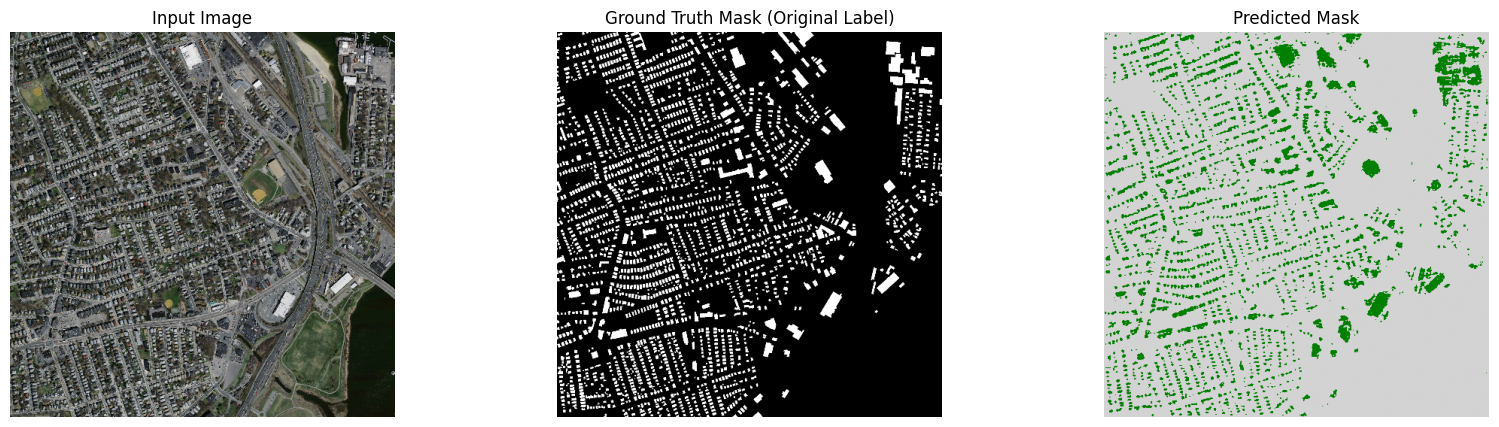

In [23]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

VAL_IMG = "/content/dataset/png/val"
VAL_MASK = "/content/dataset/png/val_labels"

pred_cmap = ListedColormap([
    "#d3d3d3",
    "red",
    "green"
])
img_name = random.choice(sorted(os.listdir(VAL_IMG)))

img_path = os.path.join(VAL_IMG, img_name)
mask_path = os.path.join(VAL_MASK, img_name)

print("Input image:", img_name)
print("Ground truth label:", img_name)

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image, (512, 512))
image_tensor = torch.tensor(image_resized / 255.0).permute(2, 0, 1).float()

gt_label = cv2.imread(mask_path)
gt_label = cv2.cvtColor(gt_label, cv2.COLOR_BGR2RGB)
gt_label = cv2.resize(gt_label, (512, 512))


model.eval()
with torch.no_grad():
    pred = model(image_tensor.unsqueeze(0).to(device))
    pred_class = torch.argmax(pred, dim=1).squeeze().cpu().numpy()


plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image_resized)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask (Original Label)")
plt.imshow(gt_label)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_class, cmap=pred_cmap, vmin=0, vmax=2)
plt.axis("off")

plt.show()
